<a href="https://colab.research.google.com/github/MinhoJu/SRT/blob/master/OilStokcs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/usr/local/lib/python3.6/dist-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


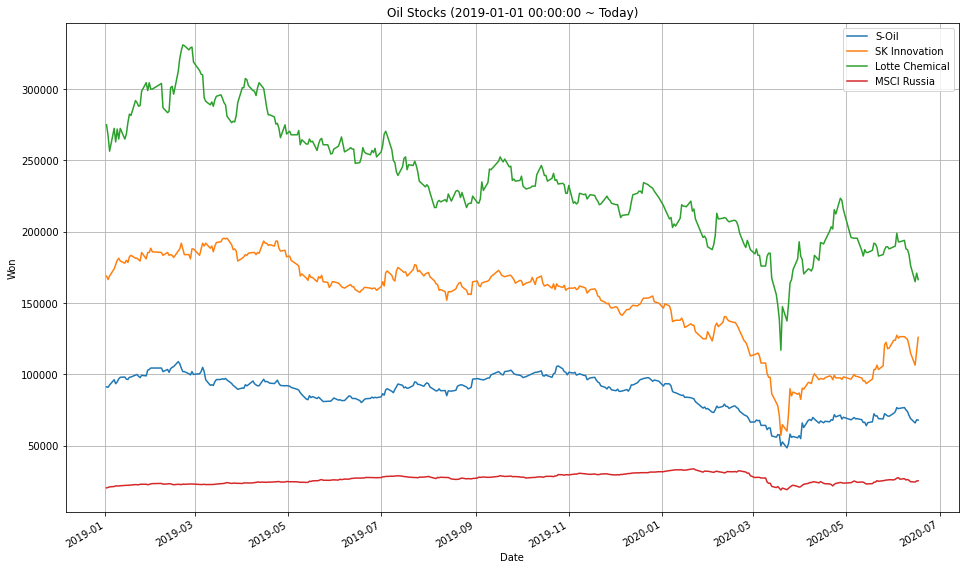

In [1]:
# https://www.datacamp.com/community/tutorials/finance-python-trading
 
# Import matplotlib 
from pandas_datareader import data
import pandas_datareader as pdr
import datetime 
from datetime import date, timedelta
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
 
start = datetime.datetime(2019, 1, 1)
end = date.today()
 
symbols = {'010950.KS':'S-Oil', '096770.KS':'SK Innovation', '011170.KS':'Lotte Chemical', '265690.KS':'MSCI Russia'}
 
df_oil = pd.DataFrame()
for symbol in symbols:
  oil = pdr.get_data_yahoo(symbol, start=start, end=end)
  df_oil[symbols[symbol]] = oil['Close']
 
# Show plot
df_oil.plot(grid=True, figsize=(16, 10))
plt.title('Oil Stocks (%s ~ Today)' % start)
plt.ylabel('Won')
plt.show()

In [2]:
def get(tickers, ticker_names, startdate, enddate):
  def data(ticker):
    return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
  datas = map (data, tickers)
  return(pd.concat(datas, keys=ticker_names, names=['Ticker', 'Date']))
  
first = '010950.KS'
second = '096770.KS'

# all_data = get(tickers, datetime.datetime(2006, 10, 1), datetime.datetime(2012, 1, 1))
all_data = get(symbols.keys(), symbols.values(), start, end)

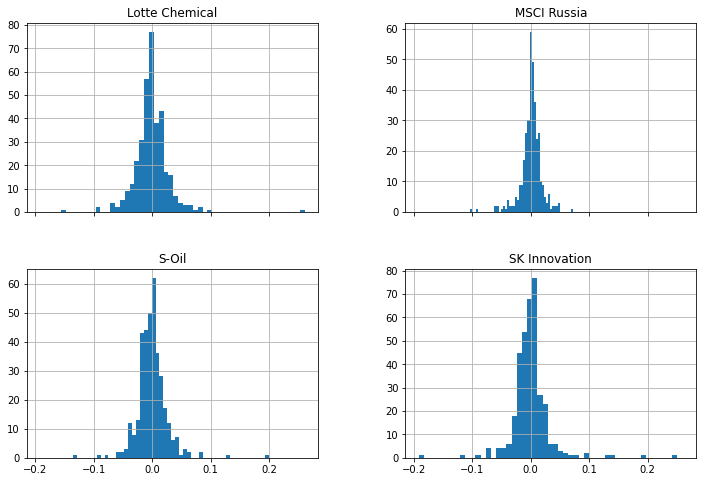

In [3]:
# Isolate the `Adj Close` values and transform the DataFrame
daily_close_px = all_data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')

# Calculate the daily percentage change for `daily_close_px`
daily_pct_change = daily_close_px.pct_change()

# Plot the distributions
daily_pct_change.hist(bins=50, sharex=True, figsize=(12,8))

# Show the resulting plot
plt.show()

Ticker      Lotte Chemical  MSCI Russia     S-Oil  SK Innovation
Date                                                            
2019-01-02             NaN          NaN       NaN            NaN
2019-01-03        0.972727     1.014146  0.996714       0.985207
2019-01-04        0.932727     1.033902  1.014239       1.000000
2019-01-07        0.990909     1.045854  1.054765       1.029586
2019-01-08        0.956364     1.067561  1.024096       1.047337
...                    ...          ...       ...            ...
2020-06-11        0.669091     1.256585  0.780942       0.713018
2020-06-12        0.641818     1.209756  0.756846       0.680473
2020-06-15        0.600000     1.200244  0.722892       0.630178
2020-06-16        0.621818     1.236341  0.746988       0.689349
2020-06-17        0.605455     1.242927  0.744797       0.745562

[359 rows x 4 columns]


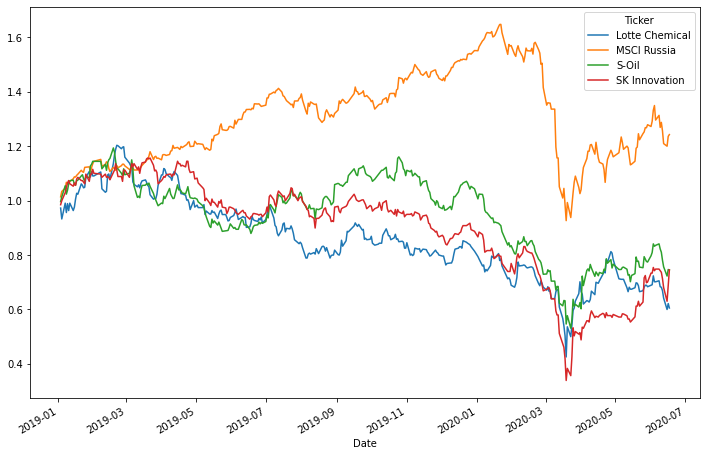

In [4]:
# Import matplotlib
import matplotlib.pyplot as plt 

# Calculate the cumulative daily returns
cum_daily_return = (1 + daily_pct_change).cumprod()

# Print `cum_daily_return`
print(cum_daily_return)

# Plot the cumulative daily returns
cum_daily_return.plot(figsize=(12,8))

# Show the plot
plt.show()

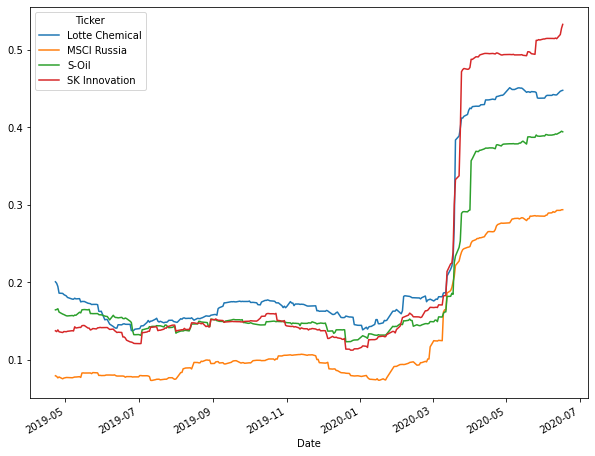

In [5]:
# Resample the cumulative daily return to cumulative monthly return 
cum_monthly_return = cum_daily_return.resample("M").mean()

# Define the minumum of periods to consider 
min_periods = 75 

# Calculate the volatility
vol = daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods) 

# Plot the volatility
vol.plot(figsize=(10, 8))

# Show the plot
plt.show()

                            OLS Regression Results                            
Dep. Variable:          SK Innovation   R-squared:                       0.572
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     473.9
Date:                Wed, 17 Jun 2020   Prob (F-statistic):           2.40e-67
Time:                        21:54:32   Log-Likelihood:                 880.99
No. Observations:                 357   AIC:                            -1758.
Df Residuals:                     355   BIC:                            -1750.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.801e-05      0.001     -0.053      0.9

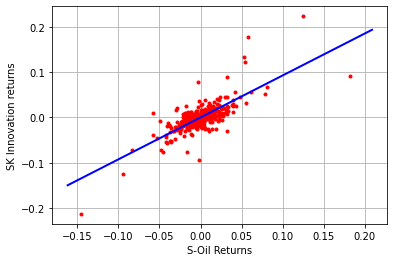

In [6]:
# Import the `api` model of `statsmodels` under alias `sm`
import statsmodels.api as sm


# Isolate the adjusted closing price
all_adj_close = all_data[['Adj Close']]

# Calculate the returns 
all_returns = np.log(all_adj_close / all_adj_close.shift(1))

first = symbols[first]
second = symbols[second]

# Isolate the AAPL returns 
aapl_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == first]
aapl_returns.index = aapl_returns.index.droplevel('Ticker')

# Isolate the MSFT returns
msft_returns = all_returns.iloc[all_returns.index.get_level_values('Ticker') == second]
msft_returns.index = msft_returns.index.droplevel('Ticker')

# Build up a new DataFrame with AAPL and MSFT returns
return_data = pd.concat([aapl_returns, msft_returns], axis=1)[1:]
return_data.columns = [first, second]
# tickers = ['010950.KS', '096770.KS', '011170.KS', '265690.KS']
# Add a constant 
X = sm.add_constant(return_data[first])

# Construct the model
model = sm.OLS(return_data[second],X).fit()

# Print the summary
print(model.summary())

# Import matplotlib
import matplotlib.pyplot as plt

# Plot returns of AAPL and MSFT
plt.plot(return_data[first], return_data[second], 'r.')

# Add an axis to the plot
ax = plt.axis()

# Initialize `x`
x = np.linspace(ax[0], ax[1] + 0.01)

# Plot the regression line
plt.plot(x, model.params[0] + model.params[1] * x, 'b', lw=2)

# Customize the plot
plt.grid(True)
plt.axis('tight')
plt.xlabel('%s Returns'%first)
plt.ylabel('%s returns'%second)

# Show the plot
plt.show()

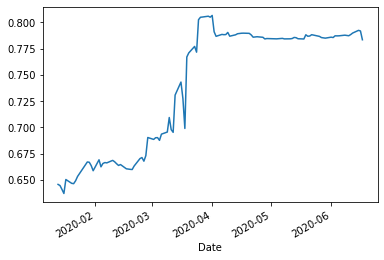

In [7]:
# Import matplotlib 
import matplotlib.pyplot as plt

# Plot the rolling correlation
return_data[second].rolling(window=252).corr(return_data[first]).plot()

# Show the plot
plt.show()

In [8]:
def buy_stategy(key_value):
  print(symbols[key_value])
 
  aapl = pdr.get_data_yahoo(key_value, start=start, end=end)
 
  # Initialize the short and long windows
  short_window = 40
  long_window = 100
 
  # Initialize the `signals` DataFrame with the `signal` column
  signals = pd.DataFrame(index=aapl.index)
  signals['signal'] = 0.0
 
  # Create short simple moving average over the short window
  signals['short_mavg'] = aapl['Close'].rolling(window=short_window, min_periods=1, center=False).mean()
 
  # Create long simple moving average over the long window
  signals['long_mavg'] = aapl['Close'].rolling(window=long_window, min_periods=1, center=False).mean()
 
  # Create signals
  signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                              > signals['long_mavg'][short_window:], 1.0, 0.0)   
 
  # Generate trading orders
  signals['positions'] = signals['signal'].diff()
 
  # Print `signals`
  print(signals)
 
  # Initialize the plot figure
  fig = plt.figure()
 
  # Add a subplot and label for y-axis
  ax1 = fig.add_subplot(111,  ylabel='Price in $')
 
  # Plot the closing price
  aapl['Close'].plot(ax=ax1, color='r', lw=2.)
 
  # Plot the short and long moving averages
  signals[['short_mavg', 'long_mavg']].plot(ax=ax1, lw=2.)
 
  # Plot the buy signals
  ax1.plot(signals.loc[signals.positions == 1.0].index, 
          signals.short_mavg[signals.positions == 1.0],
          '^', markersize=10, color='m')
          
  # Plot the sell signals
  ax1.plot(signals.loc[signals.positions == -1.0].index, 
          signals.short_mavg[signals.positions == -1.0],
          'v', markersize=10, color='k')
          
  # Show the plot
  plt.show()
 
  # Set the initial capital
  initial_capital= float(100000.0)
 
  # Create a DataFrame `positions`
  positions = pd.DataFrame(index=signals.index).fillna(0.0)
 
  # Buy a 100 shares
  positions[first] = 100*signals['signal']   
    
  # Initialize the portfolio with value owned   
  portfolio = positions.multiply(aapl['Adj Close'], axis=0)
 
  # Store the difference in shares owned 
  pos_diff = positions.diff()
 
  # Add `holdings` to portfolio
  portfolio['holdings'] = (positions.multiply(aapl['Adj Close'], axis=0)).sum(axis=1)
 
  # Add `cash` to portfolio
  portfolio['cash'] = initial_capital - (pos_diff.multiply(aapl['Adj Close'], axis=0)).sum(axis=1).cumsum()   
 
  # Add `total` to portfolio
  portfolio['total'] = portfolio['cash'] + portfolio['holdings']
 
  # Add `returns` to portfolio
  portfolio['returns'] = portfolio['total'].pct_change()
 
  # Print the first lines of `portfolio`
  print(portfolio.head())
 
  # Create a figure
  fig = plt.figure()
 
  ax1 = fig.add_subplot(111, ylabel='Portfolio value in $')
 
  # Plot the equity curve in dollars
  portfolio['total'].plot(ax=ax1, lw=2.)
 
  ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
          portfolio.total[signals.positions == 1.0],
          '^', markersize=10, color='m')
  ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
          portfolio.total[signals.positions == -1.0],
          'v', markersize=10, color='k')
 
  # Show the plot
  plt.show()
 
  print()

S-Oil
            signal    short_mavg     long_mavg  positions
Date                                                     
2019-01-02     0.0  91300.000000  91300.000000        NaN
2019-01-03     0.0  91150.000000  91150.000000        0.0
2019-01-04     0.0  91633.333333  91633.333333        0.0
2019-01-07     0.0  92800.000000  92800.000000        0.0
2019-01-08     0.0  92940.000000  92940.000000        0.0
...            ...           ...           ...        ...
2020-06-11     1.0  70145.000000  69489.000000        0.0
2020-06-12     1.0  70155.000000  69325.000000        0.0
2020-06-15     1.0  70157.500000  69146.000000        0.0
2020-06-16     1.0  70177.500000  68987.000000        0.0
2020-06-17     1.0  70225.000000  68830.000000        0.0

[358 rows x 4 columns]


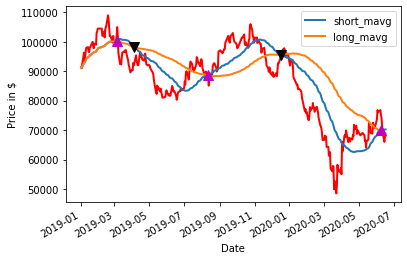

            S-Oil  holdings      cash     total  returns
Date                                                    
2019-01-02    0.0       0.0  100000.0  100000.0      NaN
2019-01-03    0.0       0.0  100000.0  100000.0      0.0
2019-01-04    0.0       0.0  100000.0  100000.0      0.0
2019-01-07    0.0       0.0  100000.0  100000.0      0.0
2019-01-08    0.0       0.0  100000.0  100000.0      0.0


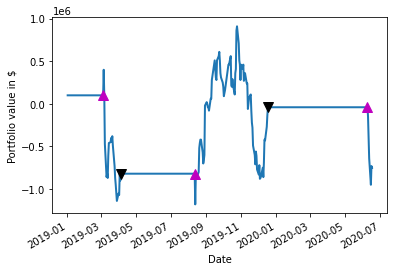


SK Innovation
            signal     short_mavg      long_mavg  positions
Date                                                       
2019-01-02     0.0  169000.000000  169000.000000        NaN
2019-01-03     0.0  167750.000000  167750.000000        0.0
2019-01-04     0.0  168166.666667  168166.666667        0.0
2019-01-07     0.0  169625.000000  169625.000000        0.0
2019-01-08     0.0  171100.000000  171100.000000        0.0
...            ...            ...            ...        ...
2020-06-11     0.0  106645.000000  109054.000000        0.0
2020-06-12     0.0  107112.500000  108874.000000        0.0
2020-06-15     0.0  107345.000000  108604.000000        0.0
2020-06-16     0.0  107840.000000  108414.000000        0.0
2020-06-17     1.0  108547.500000  108329.000000        1.0

[359 rows x 4 columns]


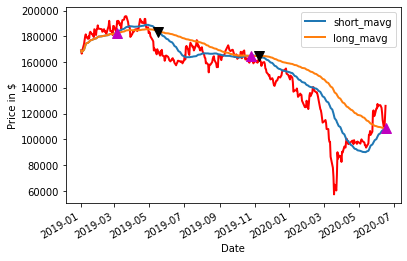

            S-Oil  holdings      cash     total  returns
Date                                                    
2019-01-02    0.0       0.0  100000.0  100000.0      NaN
2019-01-03    0.0       0.0  100000.0  100000.0      0.0
2019-01-04    0.0       0.0  100000.0  100000.0      0.0
2019-01-07    0.0       0.0  100000.0  100000.0      0.0
2019-01-08    0.0       0.0  100000.0  100000.0      0.0


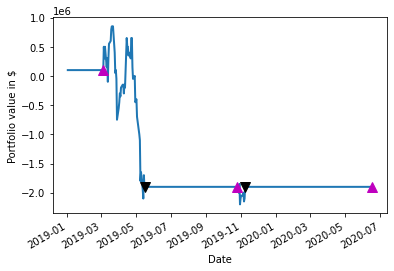


Lotte Chemical
            signal     short_mavg      long_mavg  positions
Date                                                       
2019-01-02     0.0  275000.000000  275000.000000        NaN
2019-01-03     0.0  271250.000000  271250.000000        0.0
2019-01-04     0.0  266333.333333  266333.333333        0.0
2019-01-07     0.0  267875.000000  267875.000000        0.0
2019-01-08     0.0  266900.000000  266900.000000        0.0
...            ...            ...            ...        ...
2020-06-11     1.0  193775.000000  189765.000000        0.0
2020-06-12     1.0  193600.000000  189350.000000        0.0
2020-06-15     1.0  193225.000000  188820.000000        0.0
2020-06-16     1.0  192687.500000  188355.000000        0.0
2020-06-17     1.0  192062.500000  187805.000000        0.0

[358 rows x 4 columns]


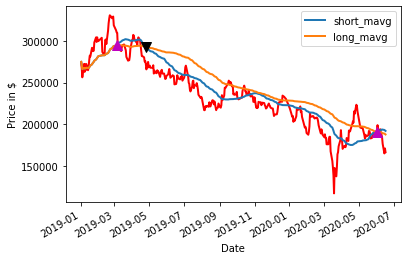

            S-Oil  holdings      cash     total  returns
Date                                                    
2019-01-02    0.0       0.0  100000.0  100000.0      NaN
2019-01-03    0.0       0.0  100000.0  100000.0      0.0
2019-01-04    0.0       0.0  100000.0  100000.0      0.0
2019-01-07    0.0       0.0  100000.0  100000.0      0.0
2019-01-08    0.0       0.0  100000.0  100000.0      0.0


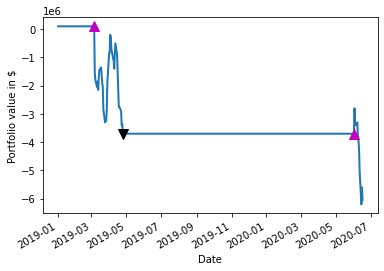


MSCI Russia
            signal    short_mavg     long_mavg  positions
Date                                                     
2019-01-02     0.0  20500.000000  20500.000000        NaN
2019-01-03     0.0  20645.000000  20645.000000        0.0
2019-01-04     0.0  20828.333333  20828.333333        0.0
2019-01-07     0.0  20981.250000  20981.250000        0.0
2019-01-08     0.0  21162.000000  21162.000000        0.0
...            ...           ...           ...        ...
2020-06-11     0.0  24814.875000  26482.600000        0.0
2020-06-12     0.0  24834.750000  26401.750000        0.0
2020-06-15     0.0  24827.375000  26317.800000        0.0
2020-06-16     0.0  24868.250000  26235.150000        0.0
2020-06-17     0.0  24920.375000  26152.150000        0.0

[359 rows x 4 columns]


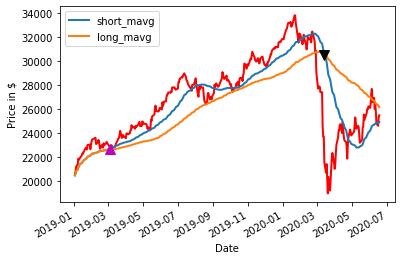

            S-Oil  holdings      cash     total  returns
Date                                                    
2019-01-02    0.0       0.0  100000.0  100000.0      NaN
2019-01-03    0.0       0.0  100000.0  100000.0      0.0
2019-01-04    0.0       0.0  100000.0  100000.0      0.0
2019-01-07    0.0       0.0  100000.0  100000.0      0.0
2019-01-08    0.0       0.0  100000.0  100000.0      0.0


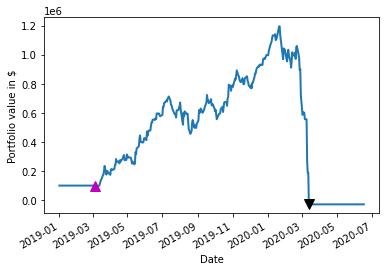

In [9]:
for k in symbols.keys():
  buy_stategy(k)
